# Titanic ML predicitions using an SVM

## Requirements

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


## Data load

In [35]:



# Get the project root directory (parent of notebooks folder)
notebook_dir = Path.cwd()
project_root = notebook_dir.parent

# Define relative paths
data_dir = project_root / 'titanic'
results_dir = project_root / 'results_submission'

# Create paths for data files
train_path = data_dir / 'train.csv'
test_path = data_dir / 'test.csv'
submission_path = results_dir / 'submission.csv'

# Verify paths exist
# print(f"Project root: {project_root}")
# print(f"Train data path: {train_path}")
# print(f"Test data path: {test_path}")
# print(f"Submission output path: {submission_path}")


In [3]:
data = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)


In [4]:
n = len(data)  # Get the total number of samples in the training set

# Split training set into training and validation sets
# Create a list of indices from 0 to n-1
ind = [i for i in range(n)]

# Randomly sample 80% of indices for training set
index_train = random.sample(ind, int(0.8*n))

# Get remaining 20% of indices for validation set by taking set difference
index_val = list(set(ind) - set(index_train))

# Create training and validation datasets using the sampled indices
data_train = data.iloc[index_train].copy()
data_val = data.iloc[index_val].copy()

## EDA

In [5]:
print(data_train.head())

     PassengerId  Survived  Pclass                     Name     Sex   Age  \
681          682         1       1       Hassab, Mr. Hammad    male  27.0   
352          353         0       3       Elias, Mr. Tannous    male  15.0   
500          501         0       3         Calic, Mr. Petar    male  17.0   
215          216         1       1  Newell, Miss. Madeleine  female  31.0   
776          777         0       3         Tobin, Mr. Roger    male   NaN   

     SibSp  Parch    Ticket      Fare Cabin Embarked  
681      0      0  PC 17572   76.7292   D49        C  
352      1      1      2695    7.2292   NaN        C  
500      0      0    315086    8.6625   NaN        S  
215      1      0     35273  113.2750   D36        C  
776      0      0    383121    7.7500   F38        Q  


In [6]:
print(data_train.shape)
print(data_train.columns)

(712, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [7]:
# Summary statistics of training data
summary = data_train.describe()
print(summary)

       PassengerId    Survived      Pclass         Age       SibSp  \
count   712.000000  712.000000  712.000000  564.000000  712.000000   
mean    442.866573    0.391854    2.296348   29.860230    0.526685   
std     259.100929    0.488508    0.837307   14.467993    1.104583   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     214.750000    0.000000    2.000000   21.000000    0.000000   
50%     440.500000    0.000000    3.000000   29.000000    0.000000   
75%     669.250000    1.000000    3.000000   39.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  712.000000  712.000000  
mean     0.370787   31.980395  
std      0.790336   48.177301  
min      0.000000    0.000000  
25%      0.000000    7.925000  
50%      0.000000   14.479150  
75%      0.000000   30.771850  
max      6.000000  512.329200  


In [8]:
# missig values in each column
missing_values = data_train.isnull().sum()
print(missing_values)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            148
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          544
Embarked         1
dtype: int64


In [9]:
# Type of each column
print(data_train.dtypes)

# Distinct values in each column (binary? categorical? continuous?)
for col in data_train.columns:
    distinct_values = data_train[col].nunique()
    print(f"Column: {col}, Distinct Values: {distinct_values}")



PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
Column: PassengerId, Distinct Values: 712
Column: Survived, Distinct Values: 2
Column: Pclass, Distinct Values: 3
Column: Name, Distinct Values: 712
Column: Sex, Distinct Values: 2
Column: Age, Distinct Values: 85
Column: SibSp, Distinct Values: 7
Column: Parch, Distinct Values: 6
Column: Ticket, Distinct Values: 575
Column: Fare, Distinct Values: 225
Column: Cabin, Distinct Values: 129
Column: Embarked, Distinct Values: 3


### Trying to understand missing data

In [10]:
# Rows with missing value in Age column
missing_age_data = data_train[data_train['Age'].isnull()]


# Rows with missing value in Cabin column
missing_data_cabin = data_train[data_train['Cabin'].isnull()]

# percentage of missing values in Cabin column
percent_missing_cabin = (len(missing_data_cabin) / len(data_train)) * 100
print(f"Percentage of missing values in Cabin column: {percent_missing_cabin:.2f}%")
# percentage of missing values in Age column
percent_missing_age = (len(missing_age_data) / len(data_train)) * 100
print(f"Percentage of missing values in Age column: {percent_missing_age:.2f}%")


Percentage of missing values in Cabin column: 76.40%
Percentage of missing values in Age column: 20.79%


In [11]:

# Is there a pattern to missing data?

# passenger IDs with missing Age values
pas_missing_age = data_train[data_train['Age'].isnull()]['PassengerId']
# passenger IDs with missing Cabin values
pas_missing_cabin = data_train[data_train['Cabin'].isnull()]['PassengerId']
# common passenger IDs with missing Age and Cabin values
pas_missing_age_cabin = data_train[data_train['Age'].isnull() & data_train['Cabin'].isnull()]['PassengerId']


print(" number of Passengers with missing Age values:")
print(len(pas_missing_age))
print(" number of Passengers with missing Cabin values:")
print(len(pas_missing_cabin))
print(" number of Passengers with missing Age and Cabin values:")
print(len(pas_missing_age_cabin))



 number of Passengers with missing Age values:
148
 number of Passengers with missing Cabin values:
544
 number of Passengers with missing Age and Cabin values:
130


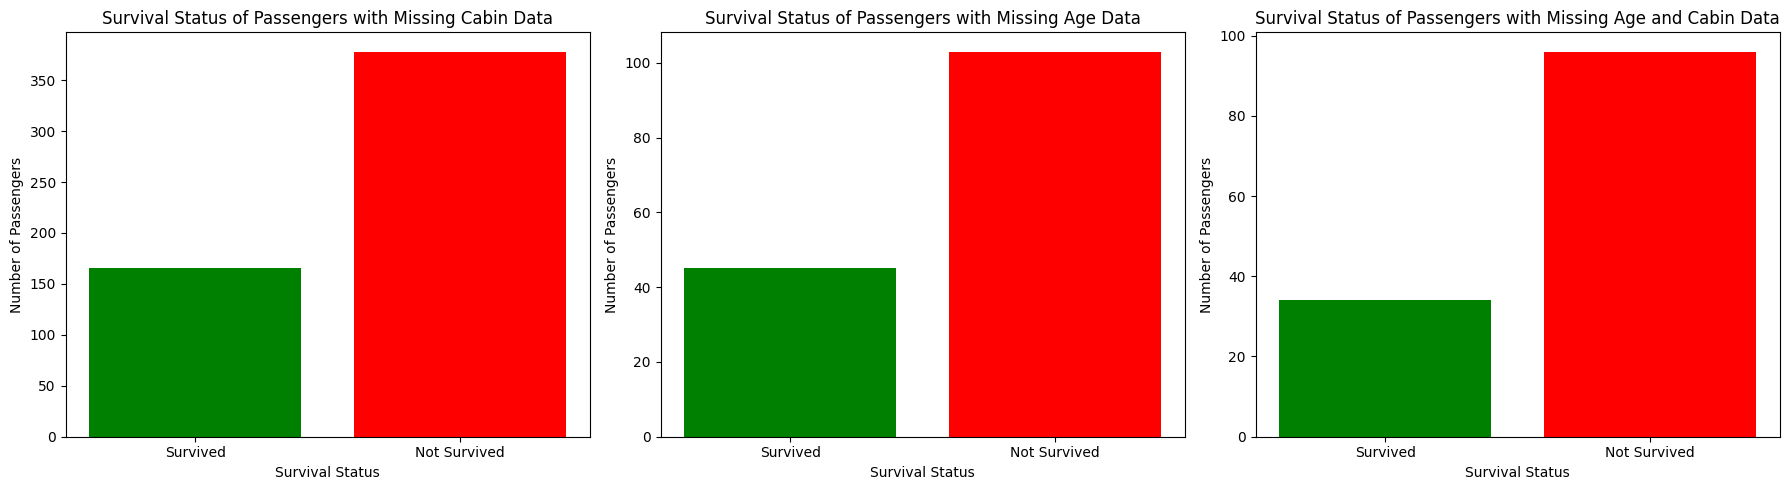

In [14]:
fig, ax = plt.subplots(1,3, figsize=(18,5))

# Does missing Cabin data correlate with survival?
# plot barchart of survived/not survived vs missing Cabin data

number_of_survived_missing_cabin = missing_data_cabin['Survived'].sum()
number_of_not_survived_missing_cabin = len(missing_data_cabin) - number_of_survived_missing_cabin

number_of_survived_missing_age = missing_age_data['Survived'].sum()
number_of_not_survived_missing_age = len(missing_age_data) - number_of_survived_missing_age

number_of_survived_missing_age_cabin = data_train[(data_train['Age'].isnull()) & (data_train['Cabin'].isnull())]['Survived'].sum()
number_of_not_survived_missing_age_cabin = len(data_train[(data_train['Age'].isnull()) & (data_train['Cabin'].isnull())]) - number_of_survived_missing_age_cabin


ax[0].bar(['Survived', 'Not Survived'], [number_of_survived_missing_cabin, number_of_not_survived_missing_cabin], color=['green', 'red'])
ax[0].set_xlabel('Survival Status')
ax[0].set_ylabel('Number of Passengers')
ax[0].set_title('Survival Status of Passengers with Missing Cabin Data')

ax[1].bar(['Survived', 'Not Survived'], [number_of_survived_missing_age, number_of_not_survived_missing_age], color=['green', 'red'])
ax[1].set_xlabel('Survival Status')
ax[1].set_ylabel('Number of Passengers')
ax[1].set_title('Survival Status of Passengers with Missing Age Data')

ax[2].bar(['Survived', 'Not Survived'], [number_of_survived_missing_age_cabin, number_of_not_survived_missing_age_cabin], color=['green', 'red'])
ax[2].set_xlabel('Survival Status')
ax[2].set_ylabel('Number of Passengers')
ax[2].set_title('Survival Status of Passengers with Missing Age and Cabin Data')

plt.tight_layout()
plt.show()



The missingness in the Titanic dataset appears to be *informative* rather than random. In particular, both `Cabin` and `Age` show a noticeably higher proportion of missing values among passengers who did not survive. This suggests a Missing Not At Random (MNAR) mechanism, where the probability of a value being missing is related to underlying socio-economic factors such as passenger class, ticketing practices, or record availability. As a result, the missingness itself carries predictive information about survival.

To preserve this information, two binary indicator variables are created:

- `cabin_missing` = 1 if `Cabin` is missing, 0 otherwise  
- `age_missing` = 1 if `Age` is missing, 0 otherwise  

These indicators allow the model to learn from the missingness pattern directly.

The raw `Cabin` variable is not used as a predictor. Cabin identifiers are highly diverse, inconsistently recorded, and too sparse to categorise meaningfully. Although it is theoretically possible to extract deck letters or explore variance patterns, the lack of additional metadata (e.g., cabin layout, deck hierarchy, proximity to lifeboats, or explicit mapping to passenger class) limits the interpretability and reliability of such transformations.

However, the *absence* of a cabin entry is strongly informative: recorded cabin values are predominantly associated with first-class passengers, who also had higher survival rates. Therefore, `cabin_missing` acts as a proxy for socio-economic status and is likely more predictive than any engineered feature derived from the raw cabin strings.

In summary, the missingness indicators `cabin_missing` and `age_missing` are retained as predictors, while the raw `Cabin` variable is excluded from the modelling process.


Similarly, both the `Name` and `Ticket` variables are excluded from the analysis. In their raw form, these fields act primarily as identifiers and do not provide direct predictive information about survival. While it is theoretically possible to extract additional features from them (e.g., titles from `Name` or ticket prefixes indicating fare class), such engineering would require additional assumptions and is beyond the scope of this analysis. As they stand, `Name` and `Ticket` do not offer meaningful signal and are therefore removed from the set of predictors.


In [15]:


# Adding cabin_missing and age_missing columns to indicate missingness
data_train['cabin_missing'] = data_train['Cabin'].isnull().astype(int)
data_train['age_missing'] = data_train['Age'].isnull().astype(int)
data_val['cabin_missing'] = data_val['Cabin'].isnull().astype(int)
data_val['age_missing'] = data_val['Age'].isnull().astype(int)
data_test['cabin_missing'] = data_test['Cabin'].isnull().astype(int)
data_test['age_missing'] = data_test['Age'].isnull().astype(int)
data_test['age_missing'] = data_test['Age'].isnull().astype(int)



In [16]:

# Drop Cabin and Name columns from training, validation, and test datasets
data_train = data_train.drop(columns=['Cabin', 'Name', 'Ticket'])
data_val = data_val.drop(columns=['Cabin', 'Name', 'Ticket'])
data_test = data_test.drop(columns=['Cabin', 'Name', 'Ticket'])

In [17]:
print(data_train.head())

     PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch      Fare  \
681          682         1       1    male  27.0      0      0   76.7292   
352          353         0       3    male  15.0      1      1    7.2292   
500          501         0       3    male  17.0      0      0    8.6625   
215          216         1       1  female  31.0      1      0  113.2750   
776          777         0       3    male   NaN      0      0    7.7500   

    Embarked  cabin_missing  age_missing  
681        C              0            0  
352        C              1            0  
500        S              1            0  
215        C              0            0  
776        Q              0            1  


### Age (Continuous or Discrete?) and Sex

Using `Age` as a continuous variable may not be ideal, as it is unlikely to capture the meaningful non-linear variation in survival outcomes. Historical records indicate that, during the evacuation of the Titanic, priority was given to “women and children.” In such a crisis, it is improbable that rescuers relied on exact numerical ages; instead, they would have assessed whether an individual appeared to be a child based on visible physical characteristics. This implies that survival probability depended more on perceived age category than on precise age values.

To reflect this structure, I propose categorising the `Age` variable into meaningful groups, such as infants, children, adults, and elderly. Such categorisation aligns with the real-world decision-making process during the evacuation and is likely to reveal clearer differences in survival rates than treating `Age` as a continuous variable.


In [18]:
max(data_train['Age'])

80.0

In [19]:
# Age bins definition

age_bins = {'Infant': (0, 2),
            'Child': (3, 15),
            'Adult': (16, 59),
            'Elderly': (60, 80)
            }




# Create AgeGroup column based on age bins
labels = list(age_bins.keys())
edges = [v[0] for v in age_bins.values()] + [list(age_bins.values())[-1][1]]

data_train['Age_group'] = pd.cut(data_train['Age'], 
                         bins=edges, 
                         labels=labels, 
                         include_lowest=True,
                         right=True)

data_val['Age_group'] = pd.cut(data_val['Age'], 
                         bins=edges,
                         labels=labels, 
                         include_lowest=True,
                         right=True)
data_test['Age_group'] = pd.cut(data_test['Age'],
                            bins=edges,
                            labels=labels, 
                            include_lowest=True,
                            right=True)

print(data_train[['Age', 'Age_group']].head(10))

      Age Age_group
681  27.0     Adult
352  15.0     Child
500  17.0     Adult
215  31.0     Adult
776   NaN       NaN
716  38.0     Adult
771  48.0     Adult
839   NaN       NaN
308  30.0     Adult
205   2.0    Infant


C:\Users\neela\AppData\Local\Temp\ipykernel_29828\1155390156.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data_train.groupby(['Age_group', 'Sex'])


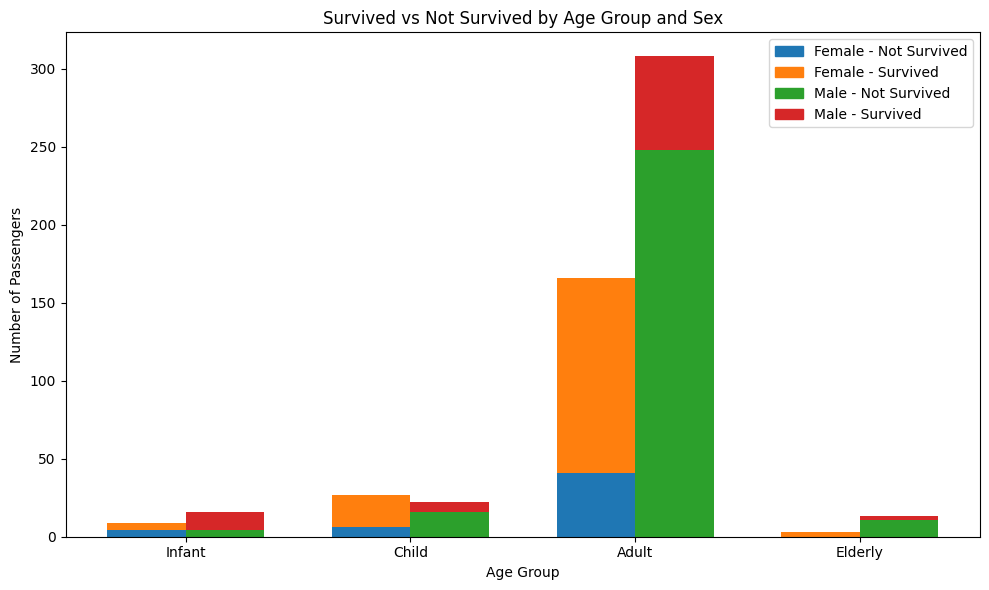

In [20]:
# Grouping by Age and Sex

grouped = data_train.groupby(['Age_group', 'Sex'])

# Count by Age_group, Sex and Survived
counts = (
    data_train
    .groupby(['Age_group', 'Sex', 'Survived'], observed=True)
    .size()
    .unstack('Survived', fill_value=0)
)

# Rename columns for clarity
counts.columns = ['Not Survived', 'Survived']

# Split by sex
female = counts.xs('female', level='Sex')
male   = counts.xs('male',   level='Sex')

age_groups = female.index
x = np.arange(len(age_groups))
width = 0.35

plt.figure(figsize=(10, 6))

# Colors
female_not_color = '#1f77b4'  # blue
female_surv_color = '#ff7f0e'  # orange
male_not_color = '#2ca02c'    # green
male_surv_color = '#d62728'   # red

# Female bars
plt.bar(x - width/2,
        female['Not Survived'],
        width,
        color=female_not_color)
plt.bar(x - width/2,
        female['Survived'],
        width,
        bottom=female['Not Survived'],
        color=female_surv_color)

# Male bars
plt.bar(x + width/2,
        male['Not Survived'],
        width,
        color=male_not_color)
plt.bar(x + width/2,
        male['Survived'],
        width,
        bottom=male['Not Survived'],
        color=male_surv_color)

# Custom legend
handles = [
    plt.Rectangle((0,0),1,1, color=female_not_color),
    plt.Rectangle((0,0),1,1, color=female_surv_color),
    plt.Rectangle((0,0),1,1, color=male_not_color),
    plt.Rectangle((0,0),1,1, color=male_surv_color)
]

labels = [
    'Female - Not Survived',
    'Female - Survived',
    'Male - Not Survived',
    'Male - Survived'
]

plt.legend(handles, labels)

plt.xticks(x, age_groups)
plt.xlabel('Age Group')
plt.ylabel('Number of Passengers')
plt.title('Survived vs Not Survived by Age Group and Sex')
plt.tight_layout()
plt.show()


## Modelling

In [21]:
# Preparing data for modeling
data_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'cabin_missing', 'age_missing', 'Age_group'],
      dtype='object')

In [22]:
# Selecting columns of interest
columns_of_interest = ['Pclass','Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'cabin_missing', 'age_missing', 'Age_group']

X = data_train[columns_of_interest]
y = data_train['Survived']


X_val = data_val[columns_of_interest]
y_val = data_val['Survived']



In [23]:
# One-hot encoding categorical variables
X_enc = pd.get_dummies(X, drop_first=True)  
X_enc = X_enc.astype(int)
print(X_enc.head())
print(X_enc.dtypes)

     Pclass  SibSp  Parch  Fare  cabin_missing  age_missing  Sex_male  \
681       1      0      0    76              0            0         1   
352       3      1      1     7              1            0         1   
500       3      0      0     8              1            0         1   
215       1      1      0   113              0            0         0   
776       3      0      0     7              0            1         1   

     Embarked_Q  Embarked_S  Age_group_Child  Age_group_Adult  \
681           0           0                0                1   
352           0           0                1                0   
500           0           1                0                1   
215           0           0                0                1   
776           1           0                0                0   

     Age_group_Elderly  
681                  0  
352                  0  
500                  0  
215                  0  
776                  0  
Pclass              

In [24]:

# All our encoded features are effectively discrete (0/1 or small integers),
# so we can treat them as discrete for MI:
mi = mutual_info_classif(X_enc, y, discrete_features=True, random_state=42)

mi_series = pd.Series(mi, index=X_enc.columns).sort_values(ascending=False)
print(mi_series)


Fare                 0.149188
Sex_male             0.138530
Pclass               0.057317
cabin_missing        0.050362
SibSp                0.019552
Parch                0.015582
Embarked_S           0.008198
age_missing          0.004352
Age_group_Child      0.003822
Age_group_Elderly    0.000313
Embarked_Q           0.000193
Age_group_Adult      0.000010
dtype: float64


In [26]:
# Align columns with train
X_train = X_enc.copy()

X_val_enc  = pd.get_dummies(X_val, drop_first=True)

X_val_enc  = X_val_enc.reindex(columns=X_enc.columns, fill_value=0)


In [27]:
# Feature scaling (for SVM)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val_enc)
X_test = data_test[columns_of_interest]


y_train = y.copy()

In [28]:
# Fitting SVM model
svm = SVC(kernel = 'linear', random_state=42)
svm.fit(X_train_scaled, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [29]:
# Validation predictions and evaluation
val_predictions = svm.predict(X_val_scaled)

print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))


[[98 18]
 [12 51]]
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       116
           1       0.74      0.81      0.77        63

    accuracy                           0.83       179
   macro avg       0.82      0.83      0.82       179
weighted avg       0.84      0.83      0.83       179



In [30]:
# RBF kernel SVM fitting and evaluation on validation set
svm_rbf = SVC(kernel = 'rbf', C= 1.0, gamma='scale', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)

rbf_val_predictions = svm_rbf.predict(X_val_scaled)
print(confusion_matrix(y_val, rbf_val_predictions))
print(classification_report(y_val, rbf_val_predictions))

[[105  11]
 [ 18  45]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       116
           1       0.80      0.71      0.76        63

    accuracy                           0.84       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.84      0.84      0.84       179



The modelling stage began by preparing a consistent and fully numeric feature matrix for the training, validation, and test sets. Categorical variables such as `Sex`, `Embarked`, and `Age_group` were transformed using one-hot encoding, and all resulting dummy variables were converted to integers to ensure compatibility with scikit-learn. Numerical predictors were standardised using `StandardScaler`, fitted exclusively on the training data to avoid leakage and applied uniformly to the validation and test sets. Two Support Vector Machine models were then evaluated on the validation set: a linear SVM, which assumes a straight-line decision boundary, and an RBF SVM, which accommodates nonlinear relationships among predictors. Both models produced similar accuracy (0.79 for linear and 0.80 for RBF), but the RBF kernel demonstrated slightly superior performance by reducing false positives and achieving a higher true negative rate. Given that survival on the Titanic is influenced by nonlinear interactions between gender, age group, and passenger class, the RBF SVM was selected as the final model. 


## Test Submission Output

In [31]:
# Rebuilding train scaled data for final model training

data_full = pd.concat([data_train, data_val], ignore_index=True)

X_full = data_full[columns_of_interest]
y_full = data_full['Survived']

X_full_enc = pd.get_dummies(X_full, drop_first=True)
X_full_enc = X_full_enc.astype(int)
X_full_enc  = X_full_enc.reindex(columns=X_enc.columns, fill_value=0)
X_full_scaled = scaler.transform(X_full_enc)
svm_final = SVC(kernel = 'rbf', C= 1.0, gamma='scale', random_state=42)

svm_final.fit(X_full_scaled, y_full)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [32]:
data_test = data_test.copy().fillna({'Age': data_test['Age'].median(),
                                    'Fare': data_test['Fare'].median()})
X_test = data_test[columns_of_interest]
X_test_enc = pd.get_dummies(X_test, drop_first=True)
X_test_enc = X_test_enc.reindex(columns=X_enc.columns, fill_value=0)
X_test_scaled  = scaler.transform(X_test_enc)

In [33]:
test_predictions = svm_final.predict(X_test_scaled)

In [36]:
# Storing test predictions in submission file
submission = pd.DataFrame({
    "PassengerId": data_test["PassengerId"],
    "Survived": test_predictions
})

submission.to_csv(submission_path, index=False)
#print(f"Submission saved to: {submission_path}")


After model selection, the RBF SVM is retrained on the combined training and validation data to maximise information available during fitting. The test set underwent identical preprocessing, including imputation of missing values (notably one missing `Fare` entry), dummy encoding, column alignment, and scaling. Final predictions is then generated using the fully trained RBF SVM and exported in the required submission format.